## Federated-Transfer learning Tutorial − Integrating Transfer learning to Federated Learning using MEDfl package

@Author : [MEDomics consortium](https://github.com/medomics/)

@Email : medomics.info@gmail.com

## Introduction

This notebook demonstrates the process of integrating [Transfer learning](https://ieeexplore.ieee.org/abstract/document/5288526/) using the *MEDfl* package. The primary objective of incorporating transfer learning with the package is to harness the capabilities of [Federated-Transfer learning](https://link.springer.com/chapter/10.1007/978-3-031-11748-0_3) in training models across different hospitals. In real-world scenarios, one of the clients or the aggregating server might possess a [pre-trained model](https://blogs.nvidia.com/blog/what-is-a-pretrained-ai-model/#:~:text=A%20pretrained%20AI%20model%20is,8%2C%202022%20by%20Angie%20Lee). Leveraging this pre-trained model offers advantages such as enhancing performance and reducing training time.

In some instances, a client may lack sufficient data to train a model entirely from scratch, hindering the ability to achieve optimal performance. Utilizing transfer learning becomes a viable strategy to maximize the benefits from each client, allowing the integration of previously learned knowledge to enhance model training and performance.

<img src="../Images/FTL_comp.png"  style="width:600px ;height:400px ; display:block ;margin:0 auto"> 

### EiCu Data 
This tutorial involves the utilization of the eICU dataset, a CSV file contains information on 200,860 patients, to train a binary classifier model.


## Tutorial Start

To integrate Transfer Learning into the *MEDfl* package, several sequential steps are essential:

1. **Importing a Pretrained Model:** Acquire or utilize a pretrained model containing learned knowledge from prior tasks or domains.
2. **Initialization at the Central Server:** The central server initiates its model by copying the pretrained model's parameters or weights.
3. **Initiating Federated Learning:** Upon initialization, the federated learning process begins, facilitating the exchange of model updates among participating clients for joint model training.

### Importing a Pretrained Model:
   - When importing a pretrained model, there are two options available:
   
     1. **Train and Save Locally:** Train a model localy, save it, and subsequently incorporate it for use.
     2. **External Source or Previous Work:** Import a pretrained model from an external source or retrieve it from a previous project.


### 1. Train and Save Localy
In this section, we aim to train a basic binary classifier model using the `eicu_sapsii_data.csv` dataset. Following the model training, we'll save the trained model for future utilization.

Imports

In [1]:
import sys
sys.path.append('../..')

import os
os.environ['PYTHONPATH'] = '../..'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from MEDfl.LearningManager.model import Model
from MEDfl.LearningManager.utils import global_params

C:\Users\HP User\AppData\Local\Temp\ipykernel_13664\1432233478.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Read the data file

In [3]:
# Read the CSV file
data = pd.read_csv(global_params['base_url'] + '/notebooks/data/masterDataSet/eICU.csv')

data.head()

,hospitalid,age,pao2fio2,uo,aids,hem,mets,admissiontype,bicarbonate,bilirubin,bun,gcs,hr,potassium,sbp,sodium,tempc,wbc,deceased
0,73,78.0,0,900.00,0.0,0.0,0.0,6.0,18.0,1.50,48.0,13.00,118.0,4.9,74.0,146.0,37.0,13.3,1
1,73,47.0,0,2300.00,0.0,0.0,0.0,6.0,27.0,0.30,12.0,15.00,106.0,4.4,99.0,138.0,36.8,8.7,0
2,60,87.0,0,1308.15,0.0,0.0,0.0,6.0,22.0,0.30,36.0,15.00,96.0,5.4,91.0,148.0,36.7,8.8,0
3,73,67.0,6,130.00,0.0,0.0,0.0,6.0,16.0,0.10,106.0,15.00,102.0,4.7,179.0,146.0,37.2,7.3,0
4,73,81.0,0,1100.00,0.0,0.0,0.0,6.0,22.0,2.36,41.0,13.45,125.0,4.5,94.0,140.0,37.3,23.5,0


#### Data Preprocessing Steps

Here, we perform several essential data preprocessing steps:

1. **Drop Unnecessary Columns:** The code drops the 'subject_id' column and any other columns deemed unnecessary for the analysis. Additional columns can be added to the `columns_to_drop` list for removal.

2. **Define Features and Target Variable:** The features are defined by selecting all columns except the 'deceased' column, which is designated as the target variable for the binary classification task.

3. **Impute Missing Values:** Missing values in the selected features are imputed using the mean strategy. The `SimpleImputer` from the scikit-learn library is employed to fill missing values in the dataset.

4. **Preview the Transformed Data:** The `.head()` function is used to display the first few rows of the transformed dataset after preprocessing.

The code snippet provides a glimpse of the preprocessing steps, ensuring data cleanliness and preparation for training the binary classifier using the eICU dataset.


In [4]:
columns_to_drop = ["hospitalid"]
data.drop(columns=columns_to_drop , inplace=True)
# Define features and target variable
features = [col for col in data.columns if col != 'deceased']
target = 'deceased'

target_counts = data['deceased'].value_counts()

# Print the counts
print(target_counts)

data.head()

deceased
0    10565
1     2328
Name: count, dtype: int64


,age,pao2fio2,uo,aids,hem,mets,admissiontype,bicarbonate,bilirubin,bun,gcs,hr,potassium,sbp,sodium,tempc,wbc,deceased
0,78.0,0,900.00,0.0,0.0,0.0,6.0,18.0,1.50,48.0,13.00,118.0,4.9,74.0,146.0,37.0,13.3,1
1,47.0,0,2300.00,0.0,0.0,0.0,6.0,27.0,0.30,12.0,15.00,106.0,4.4,99.0,138.0,36.8,8.7,0
2,87.0,0,1308.15,0.0,0.0,0.0,6.0,22.0,0.30,36.0,15.00,96.0,5.4,91.0,148.0,36.7,8.8,0
3,67.0,6,130.00,0.0,0.0,0.0,6.0,16.0,0.10,106.0,15.00,102.0,4.7,179.0,146.0,37.2,7.3,0
4,81.0,0,1100.00,0.0,0.0,0.0,6.0,22.0,2.36,41.0,13.45,125.0,4.5,94.0,140.0,37.3,23.5,0


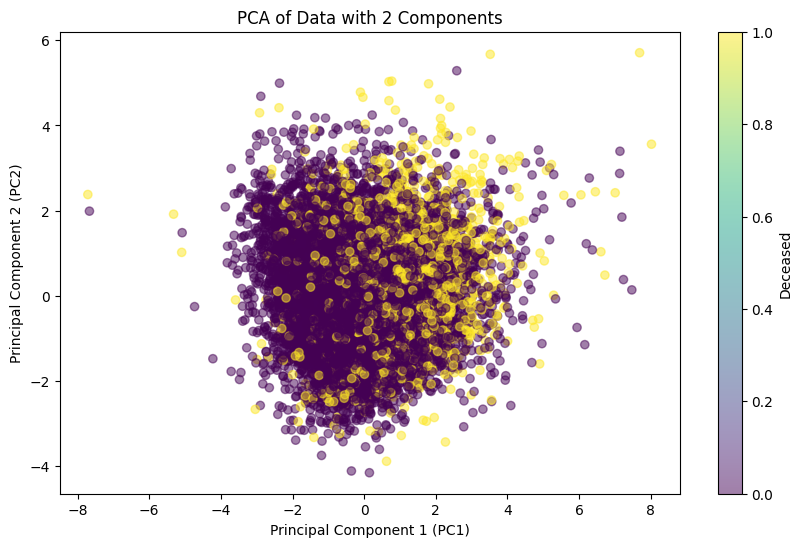

In [8]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Perform PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components and target variable
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['deceased'] = data['deceased'].values

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['deceased'], cmap='viridis', alpha=0.5)
plt.title('PCA of Data with 2 Components')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Deceased')
plt.show()


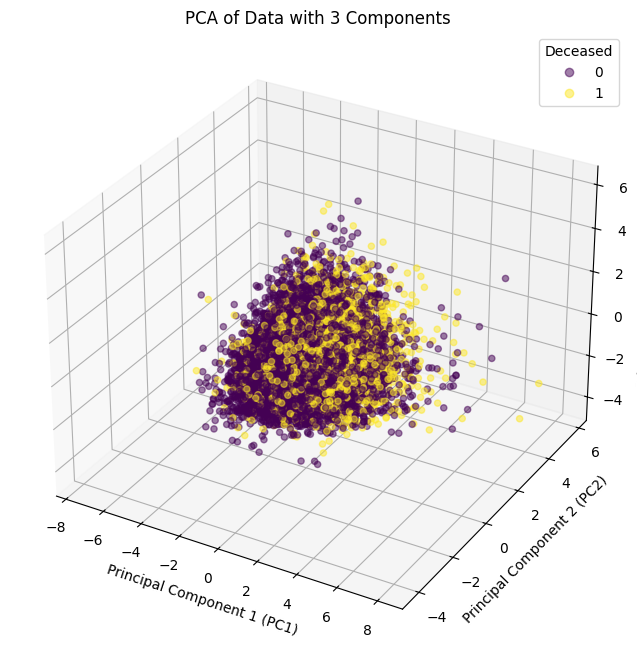

In [32]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Perform PCA with 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components and target variable
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['deceased'] = data['deceased'].values

# Plot the results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['deceased'], cmap='viridis', alpha=0.5
)
ax.set_title('PCA of Data with 3 Components')
ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')
ax.legend(*scatter.legend_elements(), title='Deceased')

plt.show()


In [5]:
from MEDfl.LearningManager.params_optimiser import ParamsOptimiser

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

trainer = ParamsOptimiser(X_train, y_train)

param_grid = {
    'hidden_dim': [5],
    'lr': [0.001 ],
    'pos_weight': [6],
    'th': [ 0.5],
    'max_epochs': [30]
}

results  = trainer.perform_grid_search(param_grid=param_grid , scoring_metric="recall")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [6]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


# Get the best model from the grid search
best_model = results.best_estimator_

# Evaluate the best model on the test data
best_model.fit(X_train_tensor.numpy(), y_train_tensor.numpy())  # Re-fit the best model on the full training data
predictions_test = best_model.predict(X_test_tensor)

# Calculate test accuracy
accuracy_test = accuracy_score(y_test_tensor.numpy(), predictions_test)
print(f"Test Accuracy: {accuracy_test:.2f}")

# Classification report and confusion matrix for test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test_tensor.numpy(), predictions_test))

print("\nConfusion Matrix (Test Data):")
tn, fp, fn, tp = confusion_matrix(y_test_tensor.numpy(), predictions_test).ravel()
print(tn, fp, fn, tp)


Test Accuracy: 0.74

Classification Report (Test Data):
              precision    recall  f1-score   support

         0.0       0.91      0.76      0.83      2132
         1.0       0.35      0.63      0.45       447

    accuracy                           0.74      2579
   macro avg       0.63      0.69      0.64      2579
weighted avg       0.81      0.74      0.76      2579


Confusion Matrix (Test Data):
1617 515 165 282


#### Modal initialisation

In [66]:


X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)


# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define the neural network model using PyTorch
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]
model = BinaryClassifier(input_dim)


# Define loss function and optimizer
pos_weight = torch.tensor([4.9 ])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Prepare data loaders for PyTorch
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)





In [52]:
input_dim

17

#### Modal Training 

In [67]:
# Train the model
epochs = 200
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader)}")

Epoch 1/200 - Loss: 1.2164715194480706
Epoch 2/200 - Loss: 1.2039369114043175
Epoch 3/200 - Loss: 1.1849560016079952
Epoch 4/200 - Loss: 1.1655459186240984
Epoch 5/200 - Loss: 1.1485349321882052
Epoch 6/200 - Loss: 1.1391905474219899
Epoch 7/200 - Loss: 1.128486079143666
Epoch 8/200 - Loss: 1.1220212770689382
Epoch 9/200 - Loss: 1.1170580774637937
Epoch 10/200 - Loss: 1.1143225798665923
Epoch 11/200 - Loss: 1.113101861240694
Epoch 12/200 - Loss: 1.1099859566511385
Epoch 13/200 - Loss: 1.1079205224757593
Epoch 14/200 - Loss: 1.109596214611833
Epoch 15/200 - Loss: 1.1069597441345544
Epoch 16/200 - Loss: 1.1033432079542531
Epoch 17/200 - Loss: 1.1045858005621116
Epoch 18/200 - Loss: 1.102741100839786
Epoch 19/200 - Loss: 1.1014465999677086
Epoch 20/200 - Loss: 1.099801855375154
Epoch 21/200 - Loss: 1.1016602933222295
Epoch 22/200 - Loss: 1.0987390014040213
Epoch 23/200 - Loss: 1.0973860424000412
Epoch 24/200 - Loss: 1.098985144966527
Epoch 25/200 - Loss: 1.0986456590540268
Epoch 26/200 - 

#### Evaluation

In [69]:
# Evaluation on test data
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = (outputs.squeeze() > 0.3).float()  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(y_test_tensor.numpy(), predictions.numpy())
print(f"Test Accuracy: {accuracy:.2f}")

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test_tensor.numpy(), predictions.numpy()))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_tensor.numpy(), predictions.numpy()))

Test Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85      2132
         1.0       0.37      0.56      0.45       447

    accuracy                           0.76      2579
   macro avg       0.63      0.68      0.65      2579
weighted avg       0.81      0.76      0.78      2579


Confusion Matrix:
[[1706  426]
 [ 195  252]]


#### Save the Trained modal

To save the trained model for future use in the Learning Manager as a pre-trained model to activate Transfer Learning, we use the `save_model` method available in the `Model` class within the *MEDfl* package. This method requires two parameters: the `model` to be saved and the `model_name`.

In [7]:
# Save the trained model 
Model.save_model(model=best_model.model , model_name='grid_search_classifier')

<generator object Module.parameters at 0x0000021516E0A970>


In [31]:
# Load the updated modal 
updated_model = Model.load_model(model_path="../.ipynb_checkpoints/trainedModels/grid_search_classifier.pth")

updated_model

Sequential(
  (0): Linear(in_features=17, out_features=70, bias=True)
  (1): ReLU()
  (2): Linear(in_features=70, out_features=1, bias=True)
  (3): Sigmoid()
)